In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-i976pre9
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-i976pre9
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264358 sha256=25f3eb06ef5113d6440ea6e2d46c308293201bf0ecb1fddc2d9e2a2972609a4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-m5k9k58h/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [2]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip 
# extract it in the current folder
unzip PennFudanPed.zip

--2022-04-01 13:37:45--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  13.6MB/s    in 4.8s    

2022-04-01 13:37:51 (10.6 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

In [3]:
import os
import torch
import numpy as np
from PIL import Image
import torch.utils.data

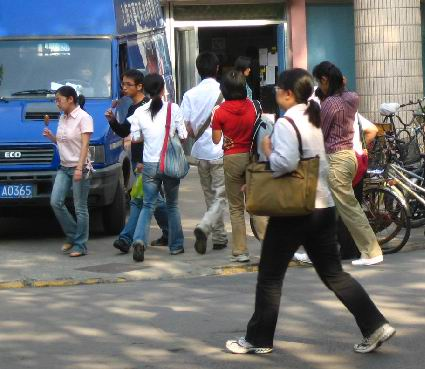

In [4]:
Image.open('PennFudanPed/PNGImages/FudanPed00025.png')

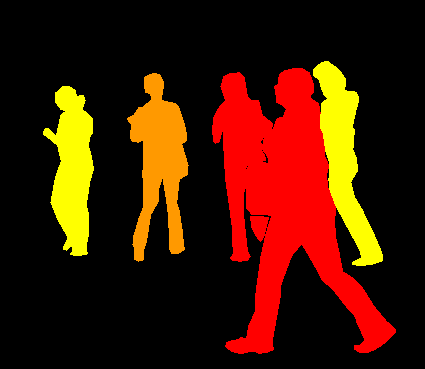

In [5]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00025_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [6]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F35FDF81550>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 114883, done.
remote: Counting objects: 100% (7567/7567), done.
remote: Compressing objects: 100% (1201/1201), done.
remote: Total 114883 (delta 6956), reused 6788 (delta 6329), pack-reused 107316
Receiving objects: 100% (114883/114883), 225.41 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (99617/99617), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [10]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

print(dataset_test)
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)



Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [15]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:02:29  lr: 0.000002  loss: 2.7890 (2.7890)  loss_classifier: 0.7472 (0.7472)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0351 (0.0351)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 2.4992  data: 0.5835  max mem: 2161
Epoch: [0]  [10/60]  eta: 0:01:25  lr: 0.000019  loss: 2.1502 (2.1248)  loss_classifier: 0.6886 (0.6240)  loss_box_reg: 0.2929 (0.3004)  loss_mask: 1.2432 (1.1741)  loss_objectness: 0.0186 (0.0214)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 1.7090  data: 0.0583  max mem: 3484
Epoch: [0]  [20/60]  eta: 0:01:04  lr: 0.000036  loss: 1.0539 (1.4950)  loss_classifier: 0.3217 (0.4190)  loss_box_reg: 0.2929 (0.2908)  loss_mask: 0.4945 (0.7659)  loss_objectness: 0.0089 (0.0149)  loss_rpn_box_reg: 0.0036 (0.0044)  time: 1.5670  data: 0.0084  max mem: 3484
Epoch: [0]  [30/60]  eta: 0:00:48  lr: 0.000053  loss: 0.6249 (1.2069)  loss_classifier: 0.1352 (0.3244)  loss_box_reg: 0.2556 (0.2854)  loss_mask: 0.2141 (0.5810)  loss_ob

In [16]:
# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [17]:
prediction

[{'boxes': tensor([[329.0685,  68.2196, 451.2190, 347.6500],
          [168.2547,  23.7976, 245.5945, 316.1994],
          [221.6547,  26.7456, 310.3380, 291.5885],
          [298.8600,  28.1619, 381.7322, 265.4258],
          [139.9846,  39.6677, 215.9810, 268.2815],
          [314.2341, 107.4186, 369.6660, 263.7625],
          [198.1099,  24.6856, 380.2479, 312.1600]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [

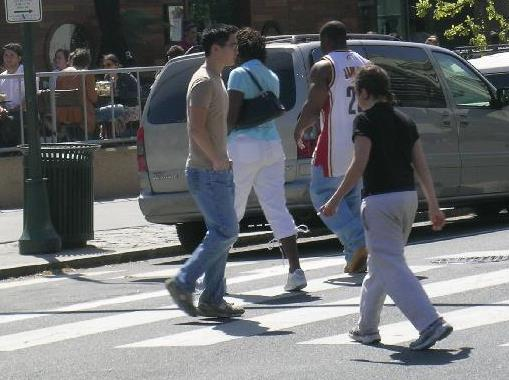

In [18]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

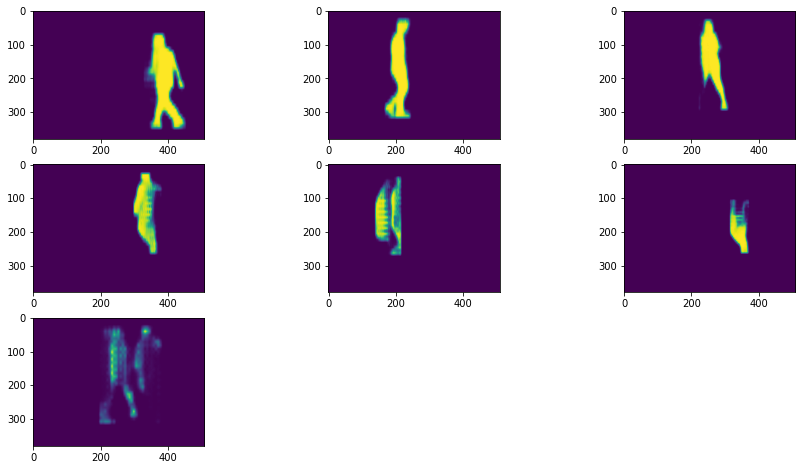

In [20]:
import matplotlib.pyplot as plt
import cv2

mask = []
for i in range( 0, len(prediction[0]['masks'])):
  mask.append(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())

plt.figure(figsize=(15,8)) # specifying the overall grid size

for i in range(len(mask)):
    plt.subplot(3,3,i+1) 
    plt.imshow(mask[i])

In [ ]:
# pick one image from the test set
img, _ = dataset_test[4]
print(dataset_test[4])
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

(tensor([[[0.1922, 0.2039, 0.1725,  ..., 0.1961, 0.2196, 0.2471],
         [0.2039, 0.1961, 0.1961,  ..., 0.1804, 0.1725, 0.1765],
         [0.2078, 0.1765, 0.2157,  ..., 0.2157, 0.2118, 0.2157],
         ...,
         [0.7725, 0.8078, 0.7765,  ..., 0.7020, 0.7098, 0.7137],
         [0.7333, 0.7686, 0.7451,  ..., 0.7020, 0.7137, 0.7216],
         [0.6824, 0.7098, 0.7098,  ..., 0.6706, 0.6745, 0.6745]],

        [[0.1765, 0.1882, 0.1686,  ..., 0.2039, 0.2314, 0.2588],
         [0.1882, 0.1804, 0.1922,  ..., 0.1882, 0.1843, 0.1882],
         [0.1922, 0.1608, 0.2118,  ..., 0.2235, 0.2235, 0.2275],
         ...,
         [0.7725, 0.8078, 0.7765,  ..., 0.7059, 0.7137, 0.7176],
         [0.7333, 0.7686, 0.7451,  ..., 0.7059, 0.7176, 0.7255],
         [0.6824, 0.7098, 0.7098,  ..., 0.6745, 0.6784, 0.6784]],

        [[0.1647, 0.1765, 0.1608,  ..., 0.1843, 0.1961, 0.2235],
         [0.1765, 0.1686, 0.1843,  ..., 0.1686, 0.1490, 0.1529],
         [0.1804, 0.1490, 0.2039,  ..., 0.2039, 0.1882, 0

In [24]:
img = Image.open("/content/my_image.jpg")
convert_tensor = T.ToTensor()
img_tensor = convert_tensor(img, target=None)

img, _ = img_tensor
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

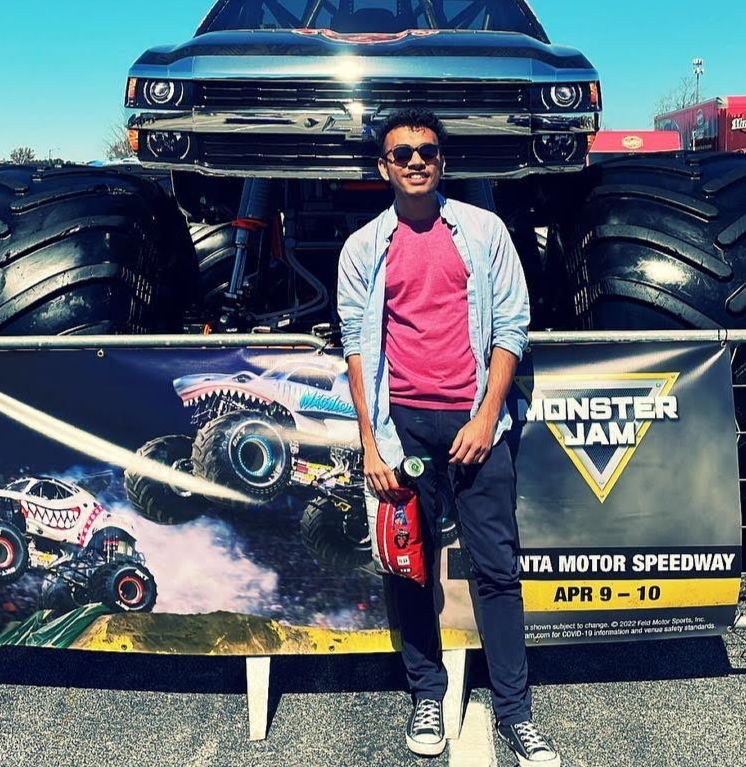

In [25]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

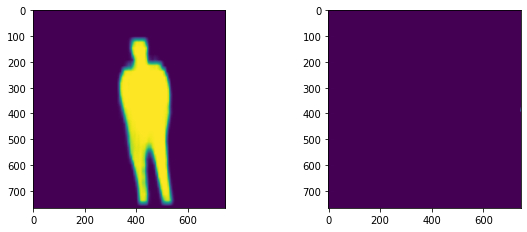

In [26]:
import numpy as np
mask = []
for i in range( 0, len(prediction[0]['masks'])):
  mask.append(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())

plt.figure(figsize=(15,8)) # specifying the overall grid size

for i in range(len(mask)):
    plt.subplot(2,3,i+1) 
    plt.imshow(mask[i])

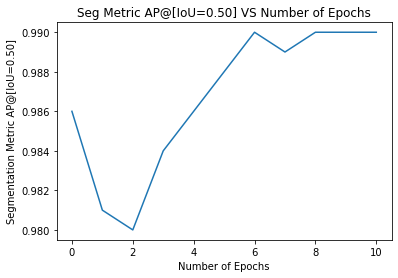

In [27]:
import numpy as np
import matplotlib.pyplot as plt

list = [0.986, 0.981, 0.980, 0.984, 0.986, 0.988, 0.990, 0.989, 0.990, 0.990, 0.990]
list = np.array(list)

plt.plot(list)
plt.title("")
title = plt.title("Seg Metric AP@[IoU=0.50] VS Number of Epochs")
ylabel = plt.ylabel("Segmentation Metric AP@[IoU=0.50]")
xlabel = plt.xlabel("Number of Epochs")

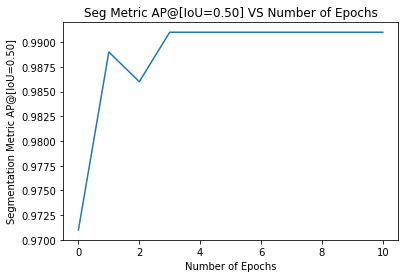

In [28]:
plist = [0.971, 0.989, 0.986, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991]

list = np.array(list)

plt.plot(list)
plt.title("")
title = plt.title("Seg Metric AP@[IoU=0.50] VS Number of Epochs")
ylabel = plt.ylabel("Segmentation Metric AP@[IoU=0.50]")
xlabel = plt.xlabel("Number of Epochs")